# Personal Finance Analytics Project

## 1. Project Overview

In this project, I analyze personal finance transaction data to understand:
- Monthly income and expenses
- Spending patterns by category (Food, Rent, Shopping, etc.)
- Savings rate over time
- Key trends and possible areas to reduce expenses

The tools used in this project:
- Python (Pandas, NumPy, Matplotlib) for data cleaning, analysis, and visualization  
- SQL for querying and aggregating data  
- Power BI for building an interactive financial dashboard

This notebook covers the **Python data analysis and preparation** part of the project.

---

## 2. Dataset Description

- Source: [Kaggle - Personal Finance Dataset] 
- Each row represents: A single financial transaction

  - date: Date of the transaction  
  - description: Description of the transaction  
  - category: Type of expense/income (Food, Rent, Salary, etc.)  
  - amount: Transaction amount (positive for income, negative for expense or vice versa)  
  - account: Account type or source (Bank, Cash, Card, etc.)

I will clean the data, create new features, perform analysis, and prepare it for SQL and Power BI.

# 2. Importing Libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
plt.rcParams['figure.figsize'] = (10, 5)

## 3. Loading Dataset
 ** In this step, I am loading personal finance dataset for analysis.

In [26]:
df = pd.read_csv("../data/personal_finance.csv")

In [27]:
df.head()

,Date,Transaction Description,Category,Amount,Type
0,2020-01-02,Score each.,Food & Drink,1485.69,Expense
1,2020-01-02,Quality throughout.,Utilities,1475.58,Expense
2,2020-01-04,Instead ahead despite measure ago.,Rent,1185.08,Expense
3,2020-01-05,Information last everything thank serve.,Investment,2291.00,Income
4,2020-01-13,Future choice whatever from.,Food & Drink,1126.88,Expense


## 3. Initial Data Exploration

In this section, I will:
- Look at the first few rows
- Check data types
- Check for missing values
- Get basic statistics

In [28]:
print("Shape of the dataset:", df.shape)

print("\nData types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isnull().sum())

print("\nBasic statistics (numeric columns):")
print(df.describe())


Shape of the dataset: (1500, 5)

Data types:
Date                           str
Transaction Description        str
Category                       str
Amount                     float64
Type                           str
dtype: object

Missing values per column:
Date                       0
Transaction Description    0
Category                   0
Amount                     0
Type                       0
dtype: int64

Basic statistics (numeric columns):
            Amount
count  1500.000000
mean   1307.520913
std     982.283361
min      14.370000
25%     629.340000
50%    1156.285000
75%    1712.932500
max    4996.000000


In [29]:
print("\nUnique values in 'category' (if present):")
if 'category' in df.columns:
    print(df['category'].value_counts().head(10))


Unique values in 'category' (if present):


## 4. Data Cleaning & Preprocessing

Steps:
- Standardize column names
- Convert "date" to datetime
- Ensure "amount" is numeric
- Handle missing values
- Remove duplicates

In [30]:
# Standardize column names

df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print("Columns after standardization:")
print(df.columns)


Columns after standardization:
Index(['date', 'transaction_description', 'category', 'amount', 'type'], dtype='str')


In [31]:
# Converting date column
# Adjusting the column name if your date column is named differently (e.g., 'transaction_date') 

df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [32]:
# Ensureing amount is numeric

df['amount'] = pd.to_numeric(df['amount'], errors='coerce')


In [33]:
# Handle missing values

if 'category' in df.columns:
    df['category'] = df['category'].fillna('Other')

if 'description' in df.columns:
    df['description'] = df['description'].fillna('Unknown')


In [34]:
# Drop rows where date or amount is missing 

df = df.dropna(subset=['date', 'amount'])


In [35]:
# Remove duplicates

before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]

print(f"Removed {before - after} duplicate rows.") 


Removed 0 duplicate rows.


In [36]:
# Quick Re-Check

df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1500 non-null   datetime64[us]
 1   transaction_description  1500 non-null   str           
 2   category                 1500 non-null   str           
 3   amount                   1500 non-null   float64       
 4   type                     1500 non-null   str           
dtypes: datetime64[us](1), float64(1), str(3)
memory usage: 58.7 KB


## 5. Feature Engineering

I will create:
- year, month, year_month
- type (income vs expense)
- abs_amount for easier aggregation

In [37]:
# Date-based features 

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month_name()
df['years_month'] = df['date'].dt.to_period('M').astype(str)


In [38]:
# Transaction type: income vs expense
# Adjust logic depending on your dataset (positive = income or expense) 

df['type'] = np.where(df['amount'] >= 0, 'income', 'expense')

In [39]:
# Absolute amount for analysis

df['abs_amount'] = df['amount'].abs()


In [40]:
# A Quick Preview

df.head()

,date,transaction_description,category,amount,type,year,month,years_month,abs_amount
0,2020-01-02,Score each.,Food & Drink,1485.69,income,2020,January,2020-01,1485.69
1,2020-01-02,Quality throughout.,Utilities,1475.58,income,2020,January,2020-01,1475.58
2,2020-01-04,Instead ahead despite measure ago.,Rent,1185.08,income,2020,January,2020-01,1185.08
3,2020-01-05,Information last everything thank serve.,Investment,2291.00,income,2020,January,2020-01,2291.00
4,2020-01-13,Future choice whatever from.,Food & Drink,1126.88,income,2020,January,2020-01,1126.88


## 6. Exploratory Data Analysis (EDA)

Questions:
- How much is spent per month?
- Which categories have the highest expenses?
- What is the monthly savings trend? (income - expense)

In [41]:
# Monthly Totals

# Separate income and expenses

income_df = df[df['type'] == 'income']
expense_df = df[df['type'] == 'expense']

monthly_income = income_df.groupby('years_month')['abs_amount'].sum()
monthly_expense = expense_df.groupby('years_month')['abs_amount'].sum()

monthly_summary = pd.DataFrame({
    'income': monthly_income,
    'expense': monthly_expense
})
monthly_summary['savings'] = monthly_summary['income'] - monthly_summary['expense']
monthly_summary

,income,expense,savings
years_month,,,
2020-01,22716.25,NaN,NaN
2020-02,37178.41,NaN,NaN
2020-03,17046.81,NaN,NaN
2020-04,23603.05,NaN,NaN
2020-05,22854.13,NaN,NaN
2020-06,33026.72,NaN,NaN
2020-07,30118.27,NaN,NaN
2020-08,46327.80,NaN,NaN
2020-09,22900.15,NaN,NaN


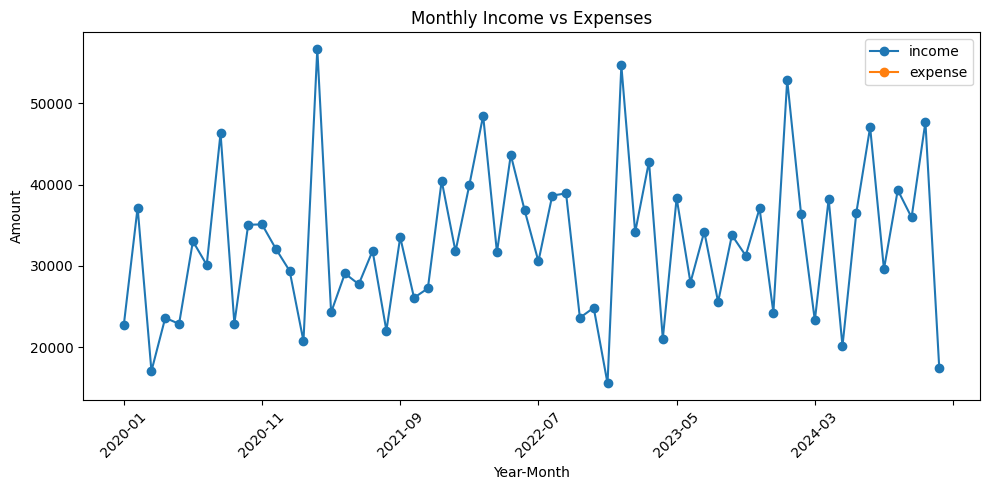

In [42]:
# Plot Monthly Income Vs Expenses

monthly_summary[['income', 'expense']].plot(kind='line', marker='o')
plt.title("Monthly Income vs Expenses")
plt.xlabel("Year-Month")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [43]:
print(df['category'].value_counts())

category
Rent                165
Travel              160
Utilities           157
Health & Fitness    152
Shopping            150
Food & Drink        149
Salary              146
Entertainment       143
Investment          142
Other               136
Name: count, dtype: int64


In [44]:
expense_categories = [
'Rent',                
'Travel',              
'Utilities',           
'Health & Fitness',    
'Shopping',            
'Food & Drink',        
'Salary',              
'Entertainment',       
'Investment',     
]     

In [45]:
df['type'] = np.where(
    df['category'].isin(expense_categories),
    'expense',
    'income'
)

In [46]:
df['type'].value_counts()

type
expense    1364
income      136
Name: count, dtype: int64

In [47]:
expense_df = df[df['type'] == 'expense']
income_df = df[df['type'] == 'income']

print("Expense rows:", expense_df.shape[0])
print("Income rows:", income_df.shape[0])

Expense rows: 1364
Income rows: 136


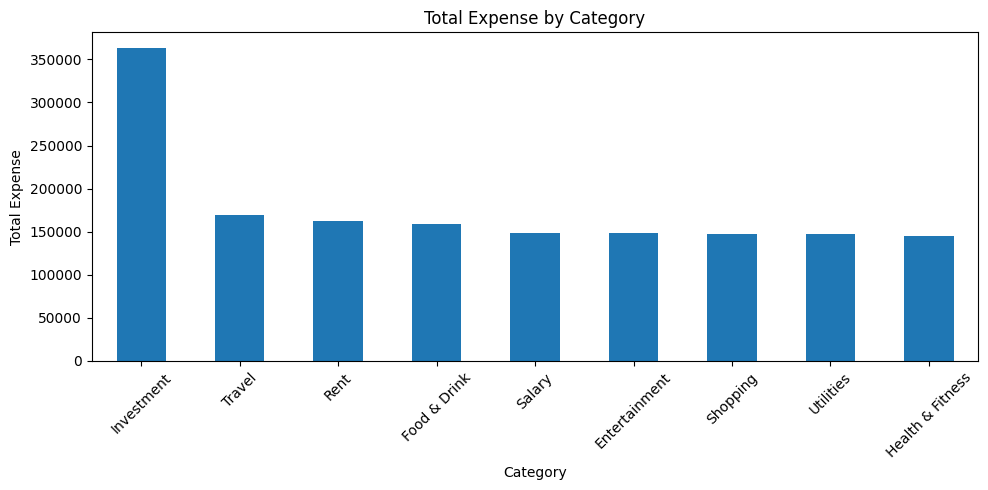

In [48]:
if not expense_df.empty:
    category_expense = (
        expense_df
        .groupby('category')['abs_amount']
        .sum()
        .sort_values(ascending=False)
    )

    category_expense.plot(kind='bar')
    plt.title("Total Expense by Category")
    plt.xlabel("Category")
    plt.ylabel("Total Expense")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    category_expense.head(10)
else:
    print("No expense data available.")

## 7. Basic Statistics & Insights

In this section, I will:
- Calculate month-over-month change in expenses
- Identify the top spending categories
- Comment on savings trends

In [49]:
# Month-over-month % change in expenses

monthly_summary['expense_pct_change'] = (
    monthly_summary['expense'].pct_change(fill_method=None) * 100
)
monthly_summary[['expense', 'expense_pct_change']].head(10)

,expense,expense_pct_change
years_month,,
2020-01,NaN,NaN
2020-02,NaN,NaN
2020-03,NaN,NaN
2020-04,NaN,NaN
2020-05,NaN,NaN
2020-06,NaN,NaN
2020-07,NaN,NaN
2020-08,NaN,NaN
2020-09,NaN,NaN


Note: The first month has NaN percentage change because there is no previous month to compare

### Observations

- The highest expense month was:   "NaN"  
- The largest increase in expenses was around:   "NaN"  
- Top 3 spending categories are:   "Investment, Travel, Rent"
- Savings were negative (overspending) in months:  "NaN"

## Saving Cleaned Dataset

I will save the cleaned and enriched dataset for use in:
- SQL database (for querying)
- Power BI dashboard (for visualization)

In [50]:
import pandas as pd

df = pd.read_csv("../data/cleaned_finance.csv")

df['date'] = pd.to_datetime(df['date'], errors='coerce')
print(df['date'].isna().sum())  # should be 0

df['date'] = df['date'].dt.strftime('%Y-%m-%d')

df.to_csv("cleaned_finance_mysql.csv", index=False)

0


##  Conclusion & Next Steps

### Key Findings
- Summary of income vs expense patterns
- Biggest spending categories
- Months with low or negative savings

### Next Steps
1. *SQL*  
   - Import cleaned_finance.csv into a SQL database table  
   -  And Writing queries to find:
     - Total Expense Amount
     - Total Income Amount
     - Monthly Expense Trend
     - Top 5 Spending Categories
     - Month With Highest Expense
     - Average Monthly Expense